## Manipulating the data
There are two important ways to manipulate these large data sets: background subtraction and symmetrisation. We shall here go through both of them, starting with background subtraction. We first need to discuss `sqw` and `dnd` objects, then we have a look at our data once more.

## A note on .sqw vs dnd objects
The data in a `sqw` object (a file or a slice/cut that is stored in memory) is a list of pixels, the calculated values of `h`, `k`, `l` and `E`, and the neutron intensities and variances. When we plot a `sqw` object, the data is binned into the chosen bins and plotted. However, the original data persits, and no information is lost, no matter which way we cut and slice a `sqw` object.
When subtracting backgroumd, we want to extrapolate the background to other regions, which is meaningless for a `sqw` object. 
To solve this problem, any `sqw` object can be converted to a `dnd` object, where the `n` is the number of dimensions. Here, we'll work with `d1d` and `d2d` objects. They are essentialy matrices with the binning defined in the cut command. Such matrices can of course be replicated and manipulated in the way we want to, to subtract the background.

All features have moved to hor_config
!==================================================================!
!          ISIS utilities for visualization and analysis           !
!                   of neutron spectroscopy data                   !
!                          Herbert 4.0.0                           !
!------------------------------------------------------------------!
All features have moved to hor_config
!==================================================================!
!                           Horace 4.0.0                           !
!------------------------------------------------------------------!
!   Visualisation of multi-dimensional neutron spectroscopy data   !
!                                                                  !
!           R.A. Ewings, A. Buts, M.D. Le, J van Duijn,            !
!                  I. Bustinduy, and T.G. Perring                  !
!                                                                  !
!             Nucl. Inst. M

*** Step 1 of 1; Read data for   107965 pixels -- processing data... ----->  retained     47529 pixels


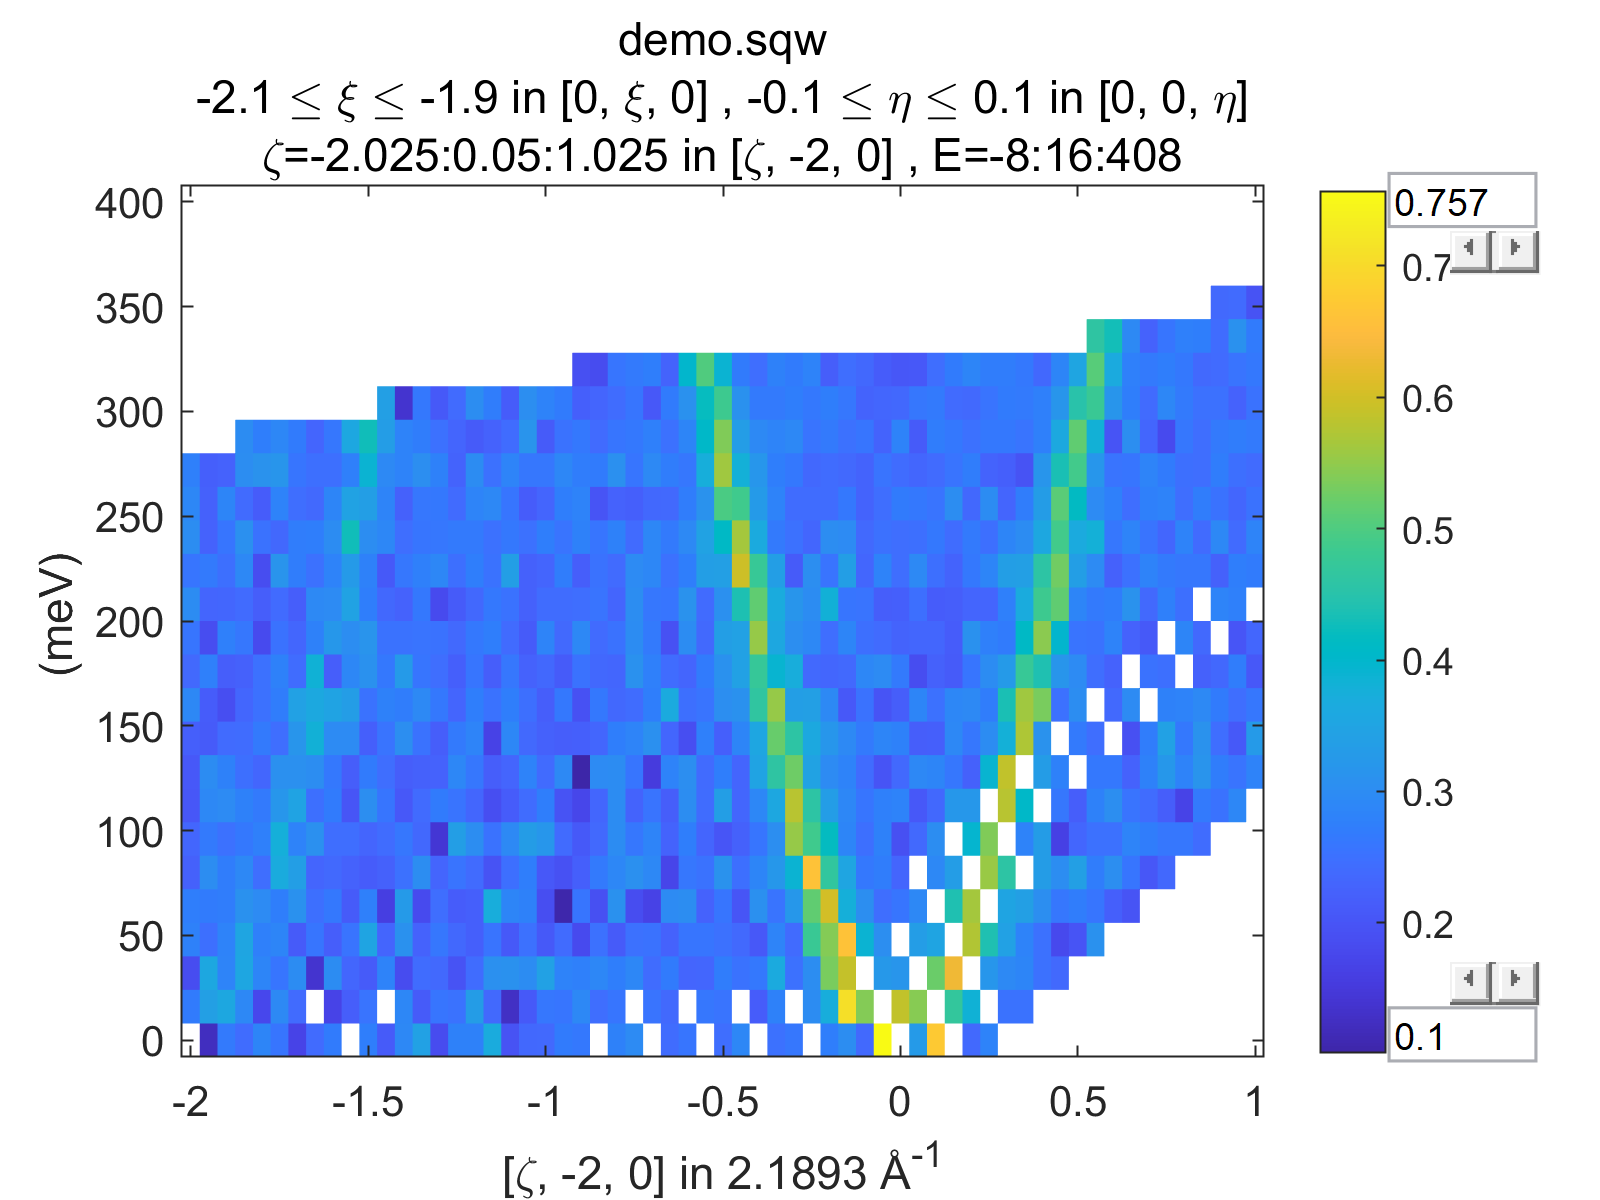

In [11]:
from pace_neutrons import Matlab
m = Matlab() 

sqw_file = 'demo.sqw'
proj = {
    'u': [1, 0, 0],
    'v': [0, 1, 0],
    'type': 'rrr'
}

%matlab_plot_mode inline inline
%matlab_fig -w 1600 -h 1200 
# 2D slice
cc2 = m.cut_sqw(sqw_file, proj, [-2, 0.05, 1], [-2-0.1, -2+0.1], [-0.1, 0.1], [0, 16, 400])
m.plot(cc2)


## Background subtraction
To subtract background, we make a 1d cut of our data set in a region with no signal, and replicate it to cover the full range of the slice. Notice that we take the cut from the 2d slice instead of the full `sqw` file. This saves time and gives the same result, as the 1d data is a subset of the 2d data.


*** Step 1 of 1; Read data for     3501 pixels -- processing data... ----->  retained      2795 pixels


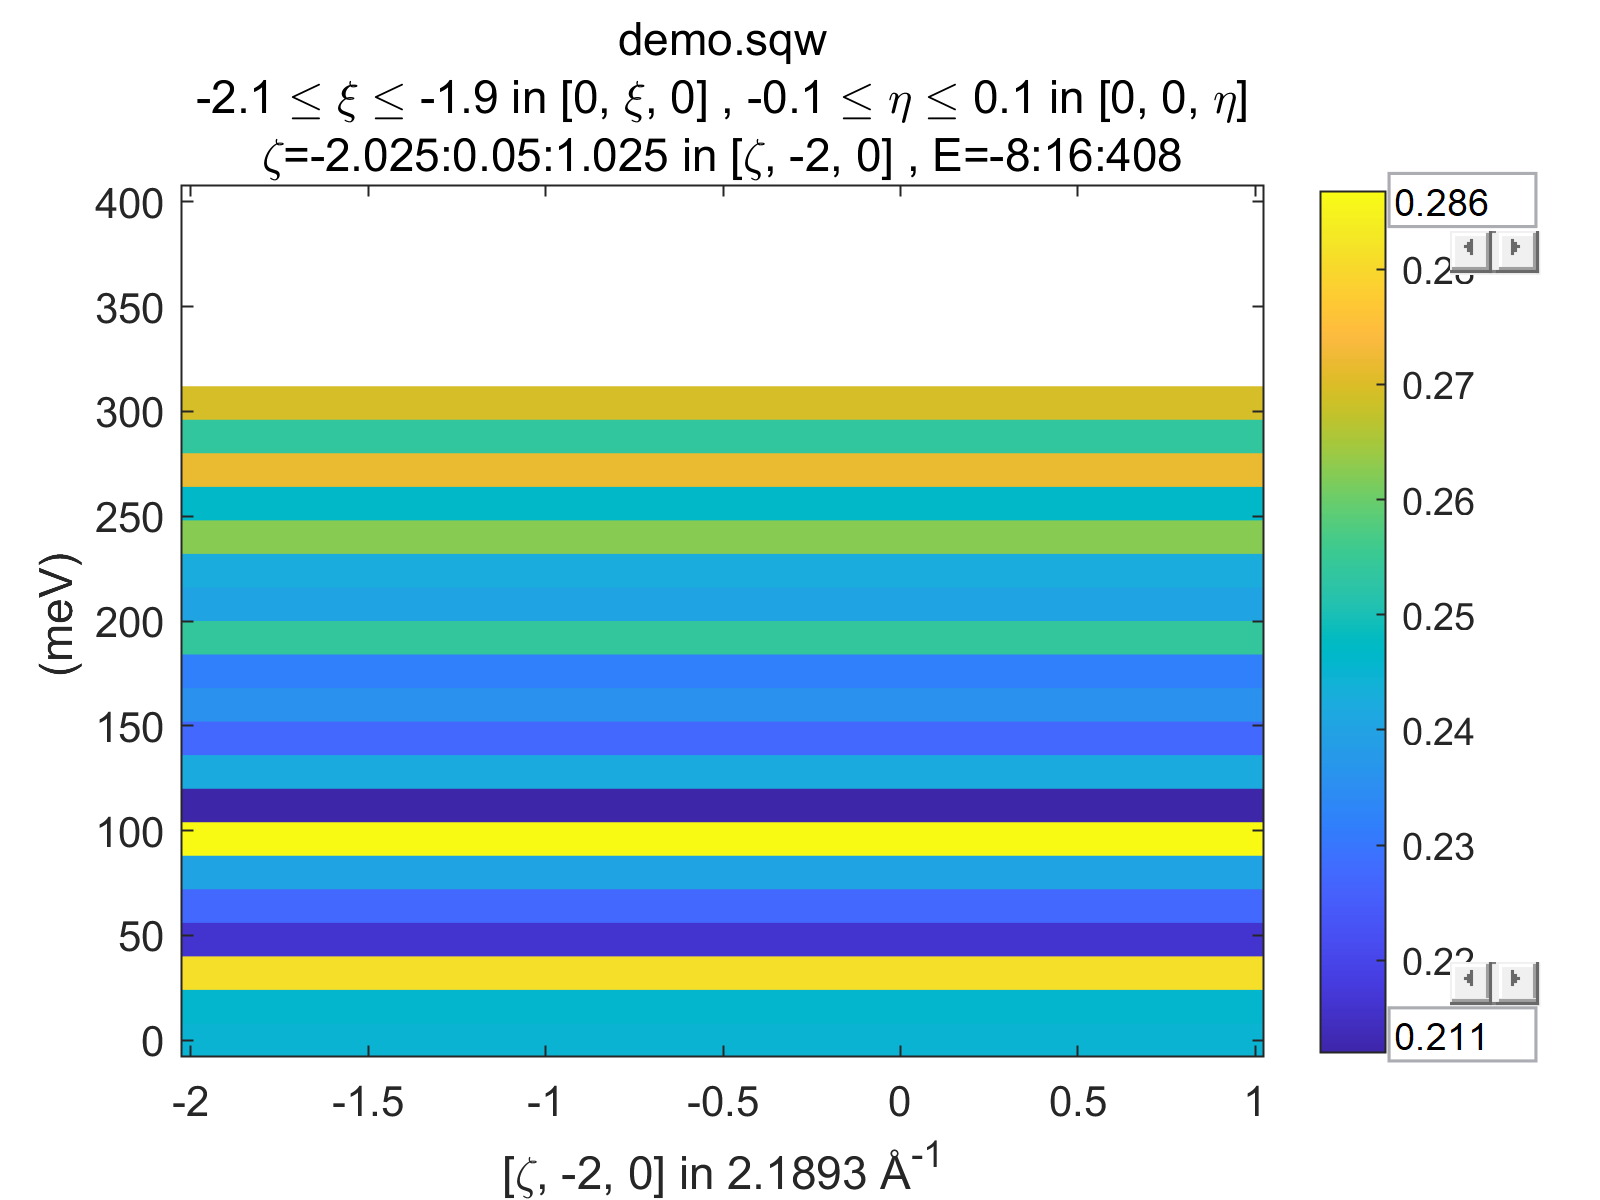

In [13]:
# Background reference
backgroundcut = m.cut(cc2, [-1.1, -0.9], [])
backgroundcut = m.d1d(backgroundcut)

# Replicate to cover full range of 2D slice
dd2 = m.d2d(cc2)
wback = m.replicate(backgroundcut, dd2)
%matlab_fig -w 1600 -h 1200 
m.plot(wback)


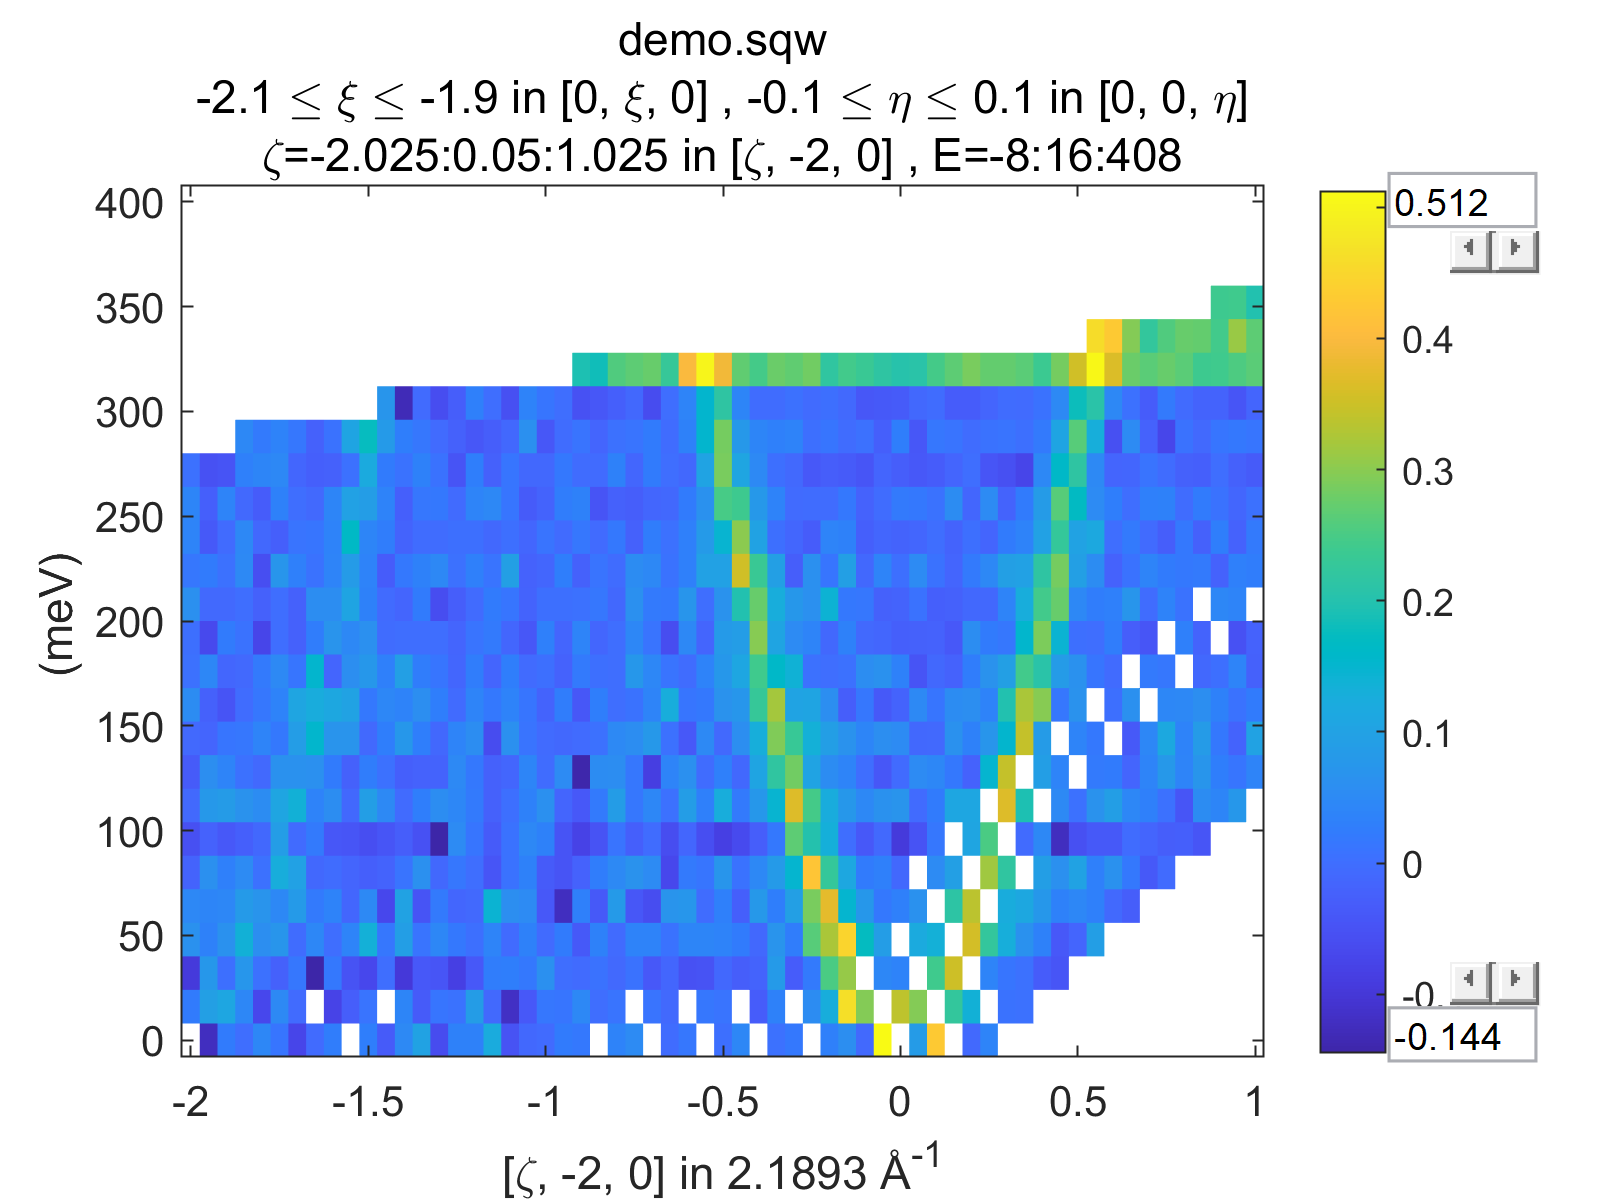

In [14]:

# Subtract from the 2D cut
wdiff = dd2 - wback
%matlab_fig -w 1600 -h 1200 
m.plot(wdiff)

In [ ]:
cc2a = m.cut_sqw(sqw_file, proj, [-3, 0.05, 3], [-3, 0.05, 3], [-0.1, 0.1], [180, 220])


In [ ]:
# w_sqw = m.sqw_eval(cc2a, m.str2func("demo_FM_spinwaves"), [250, 0, 2.4, 10, 5])

In [ ]:
demo_FM_spinwaves = m.eval('@(qh, qk, ql, en, pars) (pars(5) .* ((en ./ (1 - exp(-11.602 .* en ./ pars(4)))) .* (4 .* pars(3) .* (pars(2) + (4 * pars(1)) * ((sin(pi .* qh)).^2 + (sin(pi .* qk)).^2 + (sin(pi .* ql)).^2)))) ./ (pi .* ((en - (pars(2) + (4 * pars(1)) * ((sin(pi .* qh)).^2 + (sin(pi .* qk)).^2 + (sin(pi .* ql)).^2))).^2 + 4 .* (pars(3) .* en).^2)))')
w_sqw = m.sqw_eval(cc2a, demo_FM_spinwaves, [250, 0, 2.4, 10, 5])
m.plot(w_sqw)
# ff = m.eval('@(h,k,l) sum(bsxfun(@times, [{} {} {}], exp(bsxfun(@times, -[{} {} {}], ((1/(2*2.87)).^2 .* (h(:).^2 + k(:).^2 + l(:).^2))))), 2) + {}'.format(A, B, C, a, b, c, D));




In [ ]:




import numpy as np

def demo_FM_spinwaves(qh, qk, ql, en, pars):
    """
    Calculate the spectral weight from a Heisenberg ferromagnet for a Q-E slice
    with nearest-neighbour interactions only.
    
    Parameters:
    qh, qk, ql, en : array-like
        Arrays (or scalars) specifying the co-ordinates for point in (Q,E)-space
        where you wish to calculate the intensity.
    pars : list
        List of parameters [js, delta, gam, temp, amp].

    Returns:
    y : array-like
        Array the same size as the input arrays qvar and en, representing the intensity.
    """
    
    js, delta, gam, temp, amp = pars
    
    # Avoiding divide by zero warning equivalent in Python
    np.seterr(divide='ignore', invalid='ignore')
    
    # Calculate omega0
    omega0 = delta + (4 * js) * ((np.sin(np.pi * qh))**2 + 
                                 (np.sin(np.pi * qk))**2 + 
                                 (np.sin(np.pi * ql))**2)
    
    # Calculate the Bose factor
    Bose = en / (1 - np.exp(-11.602 * en / temp))
    
    # Use damped SHO model to give intensity
    y = amp * (Bose * (4 * gam * omega0) / 
               (np.pi * ((en - omega0)**2 + 4 * (gam * en)**2)))
    
    # Return the calculated intensity
    return y

# Example usage:
qh = np.array([0.1, 0.2, 0.3])
qk = np.array([0.1, 0.2, 0.3])
ql = np.array([0.1, 0.2, 0.3])
en = np.array([10, 20, 30])
pars = [250, 0, 2.4, 10, 5]

# Call the function and print the result
intensity = demo_FM_spinwaves(qh, qk, ql, en, pars)
print("Calculated Intensity:", intensity)


In [ ]:
"""
This a Python translation of an example script from the Horace training course.
In the original script, a multifit() model was setup and fit but this does not
work in Python at the moment because the thinwrapper around old-style Matlab 
classes does not nest (and the multifit object has a nested sqw object inside
it). So it is changed to just use sqw_eval() instead.
"""

# Have to import Matlab first before any CPython modules or will give ABI errors
from pace_neutrons import Matlab
m = Matlab()


In [ ]:

data_path = '/path/to/sqw/'

import numpy as np

# sqw_file = '{}/iron.sqw'.format(data_path)
sqw_file = 'demo2.sqw'

# If the data file doesn't exist, create a fake version
#if ~exist(sqw_file, 'file')
#    generate_iron	
#end

# Make a series of 1D cuts of the data
proj = {'u':[1,1,0], 'v':[-1,1,0], 'type':'rrr'}
energy_range = range(80, 160, 20)
my_cuts = []


In [ ]:

# Evaluating sqw_eval for a list of cuts doesn't work at the moment
for i in [0]:#range(len(energy_range)):
    my_cuts.append(m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-1.05,-0.95], [-0.05,0.05], [-10+energy_range[i], 10+energy_range[i]]));


In [ ]:

##
# Run the fitting with an analytical expression for the cross-section
#  - using an exact expression for the dispersion of a body-centered cubic 
#    FM combined with a damped harmonic oscillator for the intensity.
# The parameters of the function is: [JS Delta Gamma Temperature Amplitude]
p0 = [35, 0, 30, 10, 300];
# Expression for the dispersion
om = m.eval('@(h,k,l,e,js,d) d + (8*js)*(1-cos(pi*h).*cos(pi*k).*cos(pi*l))');

In [ ]:
# The magnetic form factor of Fe2+
A=0.0706; a=35.008;  B=0.3589; b=15.358;  C=0.5819; c=5.561;  D=-0.0114;
ff = m.eval('@(h,k,l) sum(bsxfun(@times, [{} {} {}], exp(bsxfun(@times, -[{} {} {}], ((1/(2*2.87)).^2 .* (h(:).^2 + k(:).^2 + l(:).^2))))), 2) + {}'.format(A, B, C, a, b, c, D));
# Put it altogether
m.assignin('base', 'om', om)
m.assignin('base', 'ff', ff)
fe_sqw = m.evalin('base', '@(h,k,l,e,p) ff(h,k,l).^2 .* (p(5)/pi) .* (e./(1-exp(-11.602.*e./p(4)))) .* 4.*p(3).*om(h,k,l,e,p(1),p(2)) ./ ((e.^2-om(h,k,l,e,p(1),p(2)).^2).^2 + 4.*(p(3).*e).^2)');
linear_bg = m.eval('@linear_bg');

# Starting parameters for fit
J = 35;
D_A = 0;
gam = 30;
temp = 10;
amp = 300;

# Define the equivalent Python function
def py_fe_sqw(h, k, l, e, p):
    js = p[0]
    d = p[1]
    om = d + (8*js) * (1 - np.cos(np.pi * h) * np.cos(np.pi * k) * np.cos(np.pi * l))
    q2 = ((1/(2*2.87))**2) * (h**2 + k**2 + l**2)
    ff = A * np.exp(-a*q2) + B * np.exp(-b*q2) + C * np.exp(-c*q2) + D
    return (ff**2) * (p[4]/np.pi) * (e / (1-np.exp(-11.602*e/p[3]))) * (4 * p[2] * om) / ((e**2 - om**2)**2 + 4*(p[2] * e)**2)

fe_sqw

In [ ]:
p=[35, 0, 30, 10, 300]
zeta=0.1
h=1+zeta
k=-1+zeta
l=0
e=100

py_test_result=py_fe_sqw(h, k, l, e, p)
print(py_test_result)

m_test_result=fe_sqw(h, k, l, e, p)
print(m_test_result)


In [ ]:

def ff_py(h,k,l):
    q2 = ((1/(2*2.87))**2) * (h**2 + k**2 + l**2)
    return A * np.exp(-a*q2) + B * np.exp(-b*q2) + C * np.exp(-c*q2) + D

print(ff(h,k,l))
print(ff_py(h,k,l))

In [ ]:

# Call with Matlab function
w_cal_m = m.sqw_eval(my_cuts[0], fe_sqw, [35, 0, 30, 10, 300])


In [ ]:

# Call with Python function
w_cal_py = m.sqw_eval(my_cuts[0], py_fe_sqw, [35, 0, 30, 10, 300])


In [ ]:

w_sum_m = m.cut(w_cal_m, [-999., 999.])
print("Summed counts in Matlab calculated cuts = {}".format(w_sum_m.data.s))
w_sum_py = m.cut(w_cal_py, [-999., 999.])
print("Summed counts in Python calculated cuts = {}".format(w_sum_py.data.s))


%matlab_plot_mode inline
%matlab_fig -w 1200 -h 800 

hf1 = m.plot(w_cal_m)


In [ ]:
%matlab_plot_mode inline
%matlab_fig -w 1200 -h 800 
hf2=m.plot(w_cal_py)

In [ ]:
%matlab_plot_mode inline
%matlab_fig -w 1200 -h 800 
hf2=m.plot(w_cal_py/w_cal_m)
# m.uiwait(hf1)


In [ ]:

kk = m.multifit_sqw(my_cuts[0])
kk = kk.set_fun (fe_sqw, [J, D_A, gam, temp, amp])
kk = kk.set_free ([1, 0, 1, 0, 1])
kk = kk.set_bfun (linear_bg, [0.1,0])
kk = kk.set_bfree ([1,0])
kk = kk.set_options ('list',2)

# Time it to see how long it takes to do the fit
m.tic()
wfit, fitdata = kk.fit('comp')
t_ana = m.toc()
print(t_ana)

In [ ]:
m.pl(wfit['sum'])

In [ ]:
#
# testing the lswt algorithm (https://arxiv.org/abs/1402.6069) directly for comparison,
# both for a 1d ferromagnetic and for an antiferromagnetic chain
# @author Tobias Weber <tweber@ill.fr>
# @date 24-oct-2024
# @license GPLv3, see 'LICENSE' file
#

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt


is_ferromagnetic = False  # choose ferromagnetic or antiferromagnetic 1d spin chain
only_pos_E = False        # hide magnon annihilation?


#
# magnetic sites
# "S": spin magnitude
# "Sdir": spin direction
#
if is_ferromagnetic:
	sites = [
		{ "S" : 1., "Sdir" : [ 0, 0, 1 ] },
	]
else:  # antiferromagnetic
	sites = [
		{ "S" : 1., "Sdir" : [ 0, 0, 1 ] },
		{ "S" : 1., "Sdir" : [ 0, 0, -1 ] },
	]

#
# magnetic couplings
# "sites": indices of the sites to couple
# "J": (symmetric) exchange interaction
# "DMI": (antisymmetric) Dzyaloshinskii-Moryia interaction
# "dist": distance in rlu to the next unit cell for the coupling
#
if is_ferromagnetic:
	couplings = [
		{ "sites" : [ 0, 0 ], "J" : -1., "DMI" : [ 0, 0, 0 ], "dist" : [ 1, 0, 0 ] },
	]
else:  # antiferromagnetic
	couplings = [
		{ "sites" : [ 0, 1 ], "J" : 1., "DMI" : [ 0, 0, 0 ], "dist" : [ 0, 0, 0 ] },
		{ "sites" : [ 1, 0 ], "J" : 1., "DMI" : [ 0, 0, 0 ], "dist" : [ 2, 0, 0 ] },
	]


# skew-symmetric (cross-product) matrix
def skew(vec):
	return np.array([
		[      0.,   vec[2],  -vec[1] ],
		[ -vec[2],       0.,   vec[0] ],
		[  vec[1],  -vec[0],       0. ] ])


# calculate spin rotations towards ferromagnetic order along [001]
for site in sites:
	zdir = np.array([ 0., 0., 1. ])
	Sdir = np.array(site["Sdir"]) / la.norm(site["Sdir"])
	rotaxis = np.array([ 0., 1., 0. ])
	s = 0.

	if np.allclose(Sdir, zdir):
		# spin and z axis parallel
		c = 1.
	elif np.allclose(Sdir, -zdir):
		# spin and z axis anti-parallel
		c = -1.
	else:
		# sine and cosine of the angle between spin and z axis
		rotaxis = np.cross(Sdir, zdir)
		s = la.norm(rotaxis)
		c = np.dot(Sdir, zdir)
		rotaxis /= s

	# rotation via rodrigues' formula, see (Arens 2015), p. 718 and p. 816
	rot = (1. - c) * np.outer(rotaxis, rotaxis) + np.diag([ c, c, c ]) - skew(rotaxis)*s
	site["u"] = rot[0, :] + 1j * rot[1, :]
	site["v"] = rot[2, :]

	#print(np.dot(rot, Sdir))
	#print("\nrot = \n%s\nu = %s\nv = %s" % (rot, site["u"], site["v"]))



# calculate real interaction matrices
for coupling in couplings:
	J = coupling["J"]
	coupling["J_real"] = np.diag([ J, J, J ]) + skew(coupling["DMI"])

	#print("\nJ_real =\n%s" % coupling["J_real"])


# get the energies of the dispersion at the momentum transfer Qvec
def get_energies(Qvec):
	#print("\n\nQ = %s" % Qvec)

	# fourier transform interaction matrices
	num_sites = len(sites)
	J_fourier = np.zeros((num_sites, num_sites, 3, 3), dtype = complex)
	J0_fourier = np.zeros((num_sites, num_sites, 3, 3), dtype = complex)

	for coupling in couplings:
		dist = np.array(coupling["dist"])
		J_real = coupling["J_real"]
		site1 = coupling["sites"][0]
		site2 = coupling["sites"][1]

		J_ft = J_real * np.exp(-1j * 2.*np.pi * np.dot(dist, Qvec))
		J_fourier[site1, site2] += J_ft
		J_fourier[site2, site1] += J_ft.transpose().conj()
		J0_fourier[site1, site2] += J_real
		J0_fourier[site2, site1] += J_real.transpose().conj()

	#print("\nJ_fourier =\n%s\n\nJ0_fourier =\n%s" % (J_fourier, J0_fourier))


	# hamiltonian
	H = np.zeros((2*num_sites, 2*num_sites), dtype = complex)

	for i in range(num_sites):
		S_i = sites[i]["S"]
		u_i = sites[i]["u"]
		v_i = sites[i]["v"]

		for j in range(num_sites):
			S_j = sites[j]["S"]
			u_j = sites[j]["u"]
			v_j = sites[j]["v"]
			S = 0.5 * np.sqrt(S_i * S_j)

			H[i, j] += S * np.dot(u_i, np.dot(J_fourier[i, j], u_j.conj()))
			H[i, i] -= S_j * np.dot(v_i, np.dot(J0_fourier[i, j], v_j))
			H[num_sites + i, num_sites + j] += \
				S * np.dot(u_i.conj(), np.dot(J_fourier[i, j], u_j))
			H[num_sites + i, num_sites + i] -= \
				S_j * np.dot(v_i, np.dot(J0_fourier[i, j], v_j))
			H[i, num_sites + j] += \
				S * np.dot(u_i, np.dot(J_fourier[i, j], u_j))
			H[num_sites + i, j] += \
				(S * np.dot(u_j, np.dot(J_fourier[j, i], u_i))).conj()

	#print("\nH =\n%s" % H)


	# trafo
	C = la.cholesky(H)
	signs = np.diag(np.concatenate((np.repeat(1, num_sites), np.repeat(-1, num_sites))))
	H_trafo = np.dot(C.transpose().conj(), np.dot(signs, C))

	#print("\nC =\n%s\n\nH_trafo =\n%s" % (C, H_trafo))


	# the eigenvalues of H give the energies
	Es = np.real(la.eigvals(H_trafo))
	return Es


# plot a dispersion branch
hs = []
Es = []
for h in np.linspace(-1, 1, 1024):
	try:
		Qvec = np.array([ h, 0, 0 ])
		for E in get_energies(Qvec):
			if only_pos_E and E < 0.:
				continue
			hs.append(h)
			Es.append(E)
	except la.LinAlgError:
		pass

plt.plot()
plt.xlabel("h (rlu)")
plt.ylabel("E (meV)")
plt.scatter(hs, Es, marker = '.')
plt.show()